### Imports

In [58]:
import pandas as pd
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence

import pickle
import os
import numpy as np

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import inflect
from nltk.corpus import stopwords
from scipy.stats import pearsonr
from nltk.tokenize.treebank import TreebankWordDetokenizer
import contractions
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from prettytable import PrettyTable
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Loading

In [59]:
df_train = pd.read_json("/content/drive/MyDrive/ml-project-data-try/multinli_1.0_train.jsonl", lines=True)
print(f"number of rows: {df_train.shape[0]}")
print(f"number of columns: {df_train.shape[1]}")
df_train.head()

number of rows: 392702
number of columns: 11


,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],government,neutral,31193n,31193,Conceptually cream skimming has two basic dime...,( ( Conceptually ( cream skimming ) ) ( ( has ...,(ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...,Product and geography are what make cream skim...,( ( ( Product and ) geography ) ( ( are ( what...,(ROOT (S (NP (NN Product) (CC and) (NN geograp...
1,[entailment],telephone,entailment,101457e,101457,you know during the season and i guess at at y...,( you ( ( know ( during ( ( ( the season ) and...,(ROOT (S (NP (PRP you)) (VP (VBP know) (PP (IN...,You lose the things to the following level if ...,( You ( ( ( ( lose ( the things ) ) ( to ( the...,(ROOT (S (NP (PRP You)) (VP (VBP lose) (NP (DT...
2,[entailment],fiction,entailment,134793e,134793,One of our number will carry out your instruct...,( ( One ( of ( our number ) ) ) ( ( will ( ( (...,(ROOT (S (NP (NP (CD One)) (PP (IN of) (NP (PR...,A member of my team will execute your orders w...,( ( ( A member ) ( of ( my team ) ) ) ( ( will...,(ROOT (S (NP (NP (DT A) (NN member)) (PP (IN o...
3,[entailment],fiction,entailment,37397e,37397,How do you know? All this is their information...,( ( How ( ( ( do you ) know ) ? ) ) ( ( All th...,(ROOT (S (SBARQ (WHADVP (WRB How)) (SQ (VBP do...,This information belongs to them.,( ( This information ) ( ( belongs ( to them )...,(ROOT (S (NP (DT This) (NN information)) (VP (...
4,[neutral],telephone,neutral,50563n,50563,yeah i tell you what though if you go price so...,( yeah ( i ( ( tell you ) ( what ( ( though ( ...,(ROOT (S (VP (VB yeah) (S (NP (FW i)) (VP (VB ...,The tennis shoes have a range of prices.,( ( The ( tennis shoes ) ) ( ( have ( ( a rang...,(ROOT (S (NP (DT The) (NN tennis) (NNS shoes))...


In [60]:
df_val_test_m = pd.read_json("/content/drive/MyDrive/ml-project-data-try/multinli_1.0_dev_matched.jsonl", lines=True)
print(f"number of rows: {df_val_test_m.shape[0]}")
print(f"number of columns: {df_val_test_m.shape[1]}")
df_val_test_m.head()

number of rows: 10000
number of columns: 11


,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[neutral, entailment, neutral, neutral, neutral]",slate,neutral,63735n,63735,The new rights are nice enough,( ( The ( new rights ) ) ( are ( nice enough )...,(ROOT (S (NP (DT The) (JJ new) (NNS rights)) (...,Everyone really likes the newest benefits,( Everyone ( really ( likes ( the ( newest ben...,(ROOT (S (NP (NN Everyone)) (VP (ADVP (RB real...
1,"[contradiction, contradiction, contradiction, ...",government,contradiction,91383c,91383,This site includes a list of all award winners...,( ( This site ) ( ( includes ( ( ( ( a list ) ...,(ROOT (S (NP (DT This) (NN site)) (VP (VBZ inc...,The Government Executive articles housed on th...,( ( ( The ( Government ( Executive articles ) ...,(ROOT (S (NP (NP (DT The) (NNP Government) (NN...
2,"[entailment, entailment, entailment, entailmen...",telephone,entailment,755e,755,uh i don't know i i have mixed emotions about ...,( ( ( ( uh ( i ( ( do n't ) ( know ( ( i i ) (...,(ROOT (SINV (S (S (INTJ (UH uh)) (NP (FW i)) (...,"I like him for the most part, but would still ...",( I ( ( ( ( ( ( like him ) ( for ( the ( most ...,(ROOT (S (NP (PRP I)) (VP (VP (VBP like) (NP (...
3,"[contradiction, contradiction, contradiction, ...",telephone,contradiction,78013c,78013,yeah i i think my favorite restaurant is alway...,( yeah ( ( i i ) ( think ( ( my ( favorite res...,(ROOT (S (VP (VB yeah) (NP (NP (FW i) (FW i)) ...,My favorite restaurants are always at least a ...,( ( My ( favorite restaurants ) ) ( ( ( ( are ...,(ROOT (S (NP (PRP$ My) (JJ favorite) (NNS rest...
4,"[contradiction, contradiction, contradiction, ...",telephone,contradiction,96377c,96377,i don't know um do you do a lot of camping,( i ( ( do n't ) ( know ( um ( do ( you ( do (...,(ROOT (S (NP (FW i)) (VP (VBP do) (RB n't) (VP...,I know exactly.,( I ( ( know exactly ) . ) ),(ROOT (S (NP (PRP I)) (VP (VBP know) (ADVP (RB...


In [61]:
df_val_test_mm = pd.read_json("/content/drive/MyDrive/ml-project-data-try/multinli_1.0_dev_mismatched.jsonl", lines=True)
print(f"number of rows: {df_val_test_mm.shape[0]}")
print(f"number of columns: {df_val_test_mm.shape[1]}")
df_val_test_mm.head()

number of rows: 10000
number of columns: 11


,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[contradiction, contradiction, contradiction, ...",letters,contradiction,75290c,75290,Your contribution helped make it possible for ...,( ( Your contribution ) ( ( helped ( make ( it...,(ROOT (S (NP (PRP$ Your) (NN contribution)) (V...,Your contributions were of no help with our st...,( ( Your contributions ) ( ( were ( of ( ( no ...,(ROOT (S (NP (PRP$ Your) (NNS contributions)) ...
1,"[contradiction, contradiction, contradiction, ...",verbatim,contradiction,133794c,133794,"The answer has nothing to do with their cause,...",( ( ( ( ( ( The answer ) ( ( ( ( has nothing )...,(ROOT (S (S (NP (DT The) (NN answer)) (VP (VBZ...,Dictionaries are indeed exercises in bi-unique...,( Dictionaries ( ( ( are indeed ) ( exercises ...,(ROOT (S (NP (NNS Dictionaries)) (VP (VBP are)...
2,"[contradiction, neutral, entailment, entailmen...",verbatim,entailment,3628c,3628,We serve a classic Tuscan meal that includes ...,( We ( ( serve ( ( a ( classic ( Tuscan meal )...,(ROOT (S (NP (PRP We)) (VP (VBP serve) (NP (NP...,We serve a meal of Florentine terrine.,( We ( ( serve ( ( a meal ) ( of ( Florentine ...,(ROOT (S (NP (PRP We)) (VP (VBP serve) (NP (NP...
3,"[contradiction, contradiction, contradiction, ...",letters,contradiction,89411c,89411,"A few months ago, Carl Newton and I wrote a le...","( ( ( A ( few months ) ) ago ) ( , ( ( ( ( Car...",(ROOT (S (ADVP (NP (DT A) (JJ few) (NNS months...,Carl Newton and I have never had any other pre...,( ( ( ( Carl Newton ) and ) I ) ( ( ( have nev...,(ROOT (S (NP (NP (NNP Carl) (NNP Newton)) (CC ...
4,"[entailment, entailment, entailment, entailmen...",facetoface,entailment,136158e,136158,"I was on this earth you know, I've lived on th...",( I ( ( was ( on ( ( this earth ) ( you ( know...,(ROOT (S (NP (PRP I)) (VP (VBD was) (PP (IN on...,I don't yet know the reason why I have lived o...,( I ( ( ( ( do n't ) yet ) ( ( know ( the reas...,(ROOT (S (NP (PRP I)) (VP (VBP do) (RB n't) (A...


### Data Preprocessing and Visualizations

Now let's define a few functions needed for data preprocessing. The first one will be the one that will leave only usefull columns to work with, them being gold_label (with label of relation between sentences), sentence1 (premise) and sentence2 (hypothesis), and genre of their text

In [62]:
def remove_unnecessary_data(df):
  """Remove unnecessary columns and Nan values from dataset"""
  if not df.columns.isin(['gold_label', 'genre', 'sentence1','sentence2']).any():
    raise ValueError('Dataframe not correct: columns gold_label, genre, sentence1,sentence2 shoul exist in dataframe')
  df = df[['gold_label', 'genre', 'sentence1','sentence2']]
  df = df[df["gold_label"] != "-"]
  df = df.rename(columns={'gold_label': 'label'})
  df.dropna(inplace=True)
  return df

Now let's perform such transformation for all 3 datasets

In [63]:
mnli_data_train = remove_unnecessary_data(df_train)
mnli_data_train.head()

,label,genre,sentence1,sentence2
0,neutral,government,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...
1,entailment,telephone,you know during the season and i guess at at y...,You lose the things to the following level if ...
2,entailment,fiction,One of our number will carry out your instruct...,A member of my team will execute your orders w...
3,entailment,fiction,How do you know? All this is their information...,This information belongs to them.
4,neutral,telephone,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.


In [64]:
mnli_data_val_test_m = remove_unnecessary_data(df_val_test_m)
mnli_data_val_test_m.head()

,label,genre,sentence1,sentence2
0,neutral,slate,The new rights are nice enough,Everyone really likes the newest benefits
1,contradiction,government,This site includes a list of all award winners...,The Government Executive articles housed on th...
2,entailment,telephone,uh i don't know i i have mixed emotions about ...,"I like him for the most part, but would still ..."
3,contradiction,telephone,yeah i i think my favorite restaurant is alway...,My favorite restaurants are always at least a ...
4,contradiction,telephone,i don't know um do you do a lot of camping,I know exactly.


In [65]:
mnli_data_val_test_mm = remove_unnecessary_data(df_val_test_mm)
mnli_data_val_test_mm.head()

,label,genre,sentence1,sentence2
0,contradiction,letters,Your contribution helped make it possible for ...,Your contributions were of no help with our st...
1,contradiction,verbatim,"The answer has nothing to do with their cause,...",Dictionaries are indeed exercises in bi-unique...
2,entailment,verbatim,We serve a classic Tuscan meal that includes ...,We serve a meal of Florentine terrine.
3,contradiction,letters,"A few months ago, Carl Newton and I wrote a le...",Carl Newton and I have never had any other pre...
4,entailment,facetoface,"I was on this earth you know, I've lived on th...",I don't yet know the reason why I have lived o...


As we can see, the transformation works, thus we can now perform more advanced one to get the data for further model trainings and validaition.

In [66]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', ' ', word)
        if new_word != ' ':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

In [67]:
def normalize_data(words):
  words = remove_non_ascii(words)
  words = to_lowercase(words)
  words = remove_punctuation(words)
  words = replace_numbers(words)
  words = remove_stopwords(words)
  return words

def preprocess_data(sentence):
  """Perform all steps needed to normalize data"""
  sentence = remove_URL(sentence)
  sentence = replace_contractions(sentence)
  # Tokenize
  words = nltk.word_tokenize(sentence)
  # Normalize 
  words = normalize_data(words)
  words = TreebankWordDetokenizer().detokenize(words)
  return words

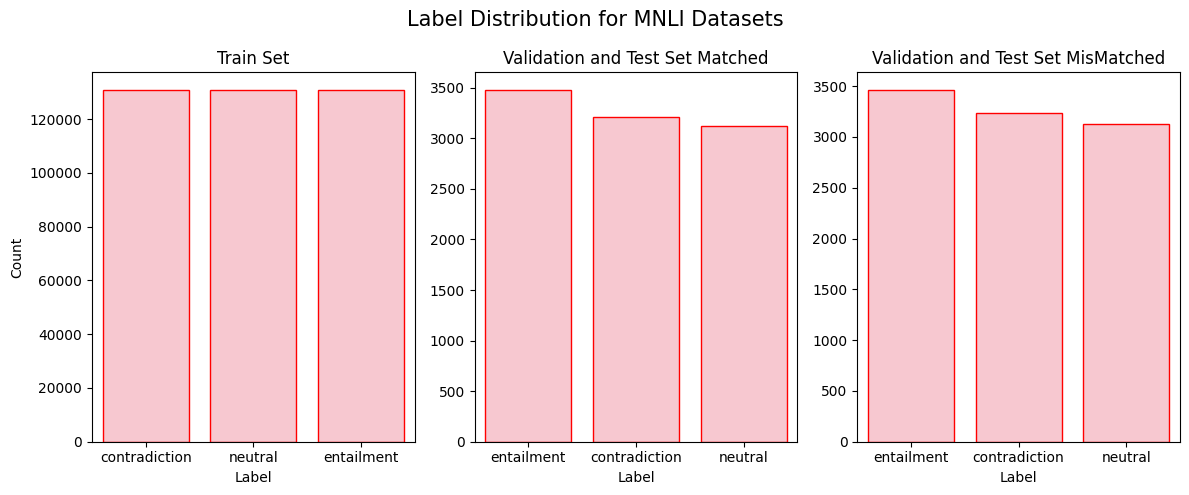

In [68]:
# Set up the figure and subplots
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Plot the count plots for train, validation-test matched and mismatched sets
sns.countplot(x='label', data=mnli_data_train, order=mnli_data_train['label'].value_counts().index, color='pink', edgecolor='red', ax=axs[0])
sns.countplot(x='label', data=mnli_data_val_test_m, order=mnli_data_val_test_m['label'].value_counts().index, color='pink', edgecolor='red', ax=axs[1])
sns.countplot(x='label', data=mnli_data_val_test_mm, order=mnli_data_val_test_mm['label'].value_counts().index, color='pink', edgecolor='red', ax=axs[2])

# Set the titles and labels for each subplot
axs[0].set_title('Train Set')
axs[1].set_title('Validation and Test Set Matched')
axs[2].set_title('Validation and Test Set MisMatched')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_xlabel('Label')
axs[1].set_xlabel('Label')
axs[2].set_xlabel('Label')

# Add a suptitle for all three plots
fig.suptitle('Label Distribution for MNLI Datasets', fontsize=15)

# Adjust the layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plots
plt.show()

Since our train dataset contains almost 400k rows, we need to work with a subset of the dataframe due to limitations of resources. For this, we decided to work with 120k rows, and have 40k rows of each label type

In [69]:
# Split the dataset by type
neutral_df = mnli_data_train[mnli_data_train['label'] == 'neutral'].reset_index(drop=True)
contradiction_df = mnli_data_train[mnli_data_train['label'] == 'contradiction'].reset_index(drop=True)
entailment_df = mnli_data_train[mnli_data_train['label'] == 'entailment'].reset_index(drop=True)

# Determine the minimum number of rows for each of the types
min_rows = 40000

# Select a random sample from each dataset
neutral_sample = neutral_df.sample(n=min_rows, random_state=42).reset_index(drop=True)
contradiction_sample = contradiction_df.sample(n=min_rows, random_state=42).reset_index(drop=True)
entailment_sample = entailment_df.sample(n=min_rows, random_state=42).reset_index(drop=True)

# Combine the selected rows
mnli_data_train = pd.concat([neutral_sample, contradiction_sample, entailment_sample], axis=0).reset_index(drop=True)
# Shuffle the rows
mnli_data_train = mnli_data_train.sample(frac=1, random_state=33).reset_index(drop=True)

In [70]:
mnli_data_train.head()

,label,genre,sentence1,sentence2
0,contradiction,telephone,but uh that that's not real life to me so,I find it to be real.
1,entailment,fiction,"I can't promise you blue-grass training, suh.",I do not promise you will get blue-grass train...
2,neutral,government,Each company had a plan for eventually achievi...,Many company's plans were hindered by a lack o...
3,entailment,travel,Elda itself is noted for excellent wine and la...,Elda has excellent wine.
4,contradiction,slate,"In 1986, he sued to block publication of Ian H...",Ian Hamilton's biography was published without...


Now let's check what is the situation with labels now in train set!

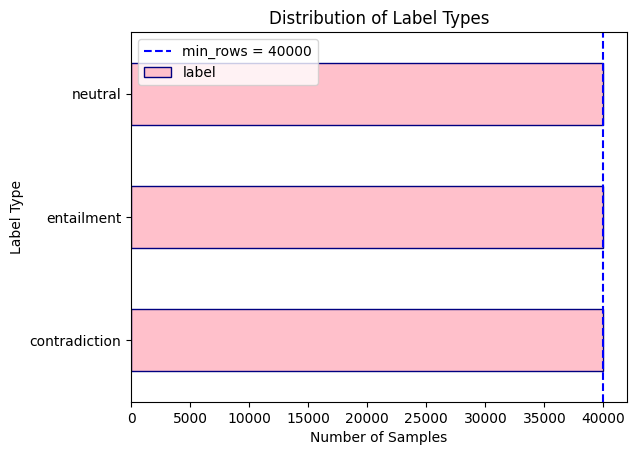

In [71]:
mnli_data_train['label'].value_counts().plot(kind='barh', color='pink', edgecolor='navy')
# Add a vertical line at x=40000
plt.axvline(x=min_rows, color='blue', linestyle='--', label=f'min_rows = {min_rows}')

# Set the title and axis labels
plt.title('Distribution of Label Types')
plt.xlabel('Number of Samples')
plt.ylabel('Label Type')
plt.legend()

Now as we can see we have equal number of relationship labels for train dataset:) for other datasets we left as it was in order to check what would be the performance of models with "not-equal" situation

Let's see what is genre distribution for our datasets

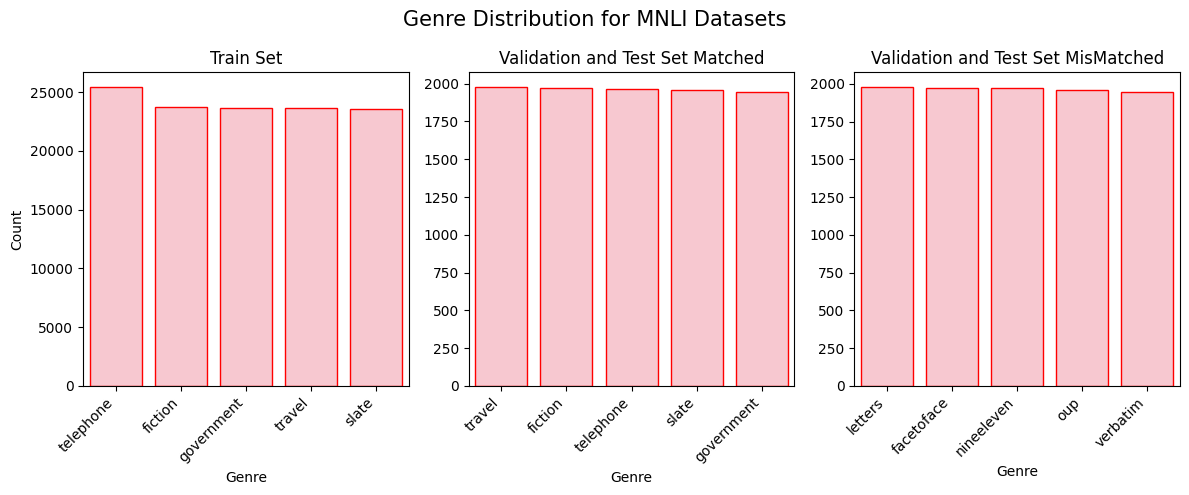

In [72]:
# Set up the figure and subplots
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Plot the count plots for train, validation-test matched and mismatched sets
sns.countplot(x='genre', data=mnli_data_train, order=mnli_data_train['genre'].value_counts().index, color='pink', edgecolor='red', ax=axs[0])
sns.countplot(x='genre', data=mnli_data_val_test_m, order=mnli_data_val_test_m['genre'].value_counts().index, color='pink', edgecolor='red', ax=axs[1])
sns.countplot(x='genre', data=mnli_data_val_test_mm, order=mnli_data_val_test_mm['genre'].value_counts().index, color='pink', edgecolor='red', ax=axs[2])

# Set the titles and labels for each subplot
axs[0].set_title('Train Set')
axs[1].set_title('Validation and Test Set Matched')
axs[2].set_title('Validation and Test Set MisMatched')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_xlabel('Genre')
axs[1].set_xlabel('Genre')
axs[2].set_xlabel('Genre')

# Rotate the genre labels to prevent overlapping
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')

# Add a suptitle for all three plots
fig.suptitle('Genre Distribution for MNLI Datasets', fontsize=15)

# Adjust the layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plots
plt.show()

Let's finally normalize our datasets! It will take a while because of the amount of data we have, starting from train set

In [73]:
mnli_data_train['premise'] = mnli_data_train.apply(lambda x: preprocess_data(x.sentence1), axis=1)
mnli_data_train['hypothesis'] = mnli_data_train.apply(lambda x: preprocess_data(x.sentence2), axis=1)
mnli_data_train.head()

,label,genre,sentence1,sentence2,premise,hypothesis
0,contradiction,telephone,but uh that that's not real life to me so,I find it to be real.,uh real life,find real
1,entailment,fiction,"I can't promise you blue-grass training, suh.",I do not promise you will get blue-grass train...,promise blue grass training suh,promise get blue grass training
2,neutral,government,Each company had a plan for eventually achievi...,Many company's plans were hindered by a lack o...,company plan eventually achieving quantum leap...,many company s plans hindered lack resources
3,entailment,travel,Elda itself is noted for excellent wine and la...,Elda has excellent wine.,elda noted excellent wine lace making,elda excellent wine
4,contradiction,slate,"In 1986, he sued to block publication of Ian H...",Ian Hamilton's biography was published without...,"one thousand, nine hundred and eighty-six sued...",ian hamilton s biography published without ch...


In [74]:
mnli_data_train = mnli_data_train.drop(['sentence1', 'sentence2'], axis=1)
mnli_data_train.head()

,label,genre,premise,hypothesis
0,contradiction,telephone,uh real life,find real
1,entailment,fiction,promise blue grass training suh,promise get blue grass training
2,neutral,government,company plan eventually achieving quantum leap...,many company s plans hindered lack resources
3,entailment,travel,elda noted excellent wine lace making,elda excellent wine
4,contradiction,slate,"one thousand, nine hundred and eighty-six sued...",ian hamilton s biography published without ch...


Now let's do the same but for matched and mismatched sets

In [75]:
mnli_data_val_test_m['premise'] = mnli_data_val_test_m.apply(lambda x: preprocess_data(x.sentence1), axis=1)
mnli_data_val_test_m['hypothesis'] = mnli_data_val_test_m.apply(lambda x: preprocess_data(x.sentence2), axis=1)
mnli_data_val_test_m.head()

,label,genre,sentence1,sentence2,premise,hypothesis
0,neutral,slate,The new rights are nice enough,Everyone really likes the newest benefits,new rights nice enough,everyone really likes newest benefits
1,contradiction,government,This site includes a list of all award winners...,The Government Executive articles housed on th...,site includes list award winners searchable da...,government executive articles housed website a...
2,entailment,telephone,uh i don't know i i have mixed emotions about ...,"I like him for the most part, but would still ...",uh know mixed emotions uh sometimes like times...,like part would still enjoy seeing someone beat
3,contradiction,telephone,yeah i i think my favorite restaurant is alway...,My favorite restaurants are always at least a ...,yeah think favorite restaurant always one clos...,favorite restaurants always least hundred mile...
4,contradiction,telephone,i don't know um do you do a lot of camping,I know exactly.,know um lot camping,know exactly


In [76]:
mnli_data_val_test_m = mnli_data_val_test_m.drop(['sentence1', 'sentence2'], axis=1)
mnli_data_val_test_m.head()

,label,genre,premise,hypothesis
0,neutral,slate,new rights nice enough,everyone really likes newest benefits
1,contradiction,government,site includes list award winners searchable da...,government executive articles housed website a...
2,entailment,telephone,uh know mixed emotions uh sometimes like times...,like part would still enjoy seeing someone beat
3,contradiction,telephone,yeah think favorite restaurant always one clos...,favorite restaurants always least hundred mile...
4,contradiction,telephone,know um lot camping,know exactly


In [77]:
mnli_data_val_test_mm['premise'] = mnli_data_val_test_mm.apply(lambda x: preprocess_data(x.sentence1), axis=1)
mnli_data_val_test_mm['hypothesis'] = mnli_data_val_test_mm.apply(lambda x: preprocess_data(x.sentence2), axis=1)
mnli_data_val_test_mm.head()

,label,genre,sentence1,sentence2,premise,hypothesis
0,contradiction,letters,Your contribution helped make it possible for ...,Your contributions were of no help with our st...,contribution helped make possible us provide s...,contributions help students education
1,contradiction,verbatim,"The answer has nothing to do with their cause,...",Dictionaries are indeed exercises in bi-unique...,answer nothing however simple fact dictionarie...,dictionaries indeed exercises bi unique substi...
2,entailment,verbatim,We serve a classic Tuscan meal that includes ...,We serve a meal of Florentine terrine.,serve classic tuscan meal includes florentine ...,serve meal florentine terrine
3,contradiction,letters,"A few months ago, Carl Newton and I wrote a le...",Carl Newton and I have never had any other pre...,months ago carl newton wrote letter asking con...,carl newton never previous contact
4,entailment,facetoface,"I was on this earth you know, I've lived on th...",I don't yet know the reason why I have lived o...,earth know lived earth reason know yet,yet know reason lived earth


In [78]:
mnli_data_val_test_mm = mnli_data_val_test_mm.drop(['sentence1', 'sentence2'], axis=1)
mnli_data_val_test_mm.head()

,label,genre,premise,hypothesis
0,contradiction,letters,contribution helped make possible us provide s...,contributions help students education
1,contradiction,verbatim,answer nothing however simple fact dictionarie...,dictionaries indeed exercises bi unique substi...
2,entailment,verbatim,serve classic tuscan meal includes florentine ...,serve meal florentine terrine
3,contradiction,letters,months ago carl newton wrote letter asking con...,carl newton never previous contact
4,entailment,facetoface,earth know lived earth reason know yet,yet know reason lived earth


Now let's analyze what is the situation with word count for our hypothesis and premise columns for train dataset. We will create columns for word count for both premise and hypothesis columns. Let's look what we have as a result

In [79]:
mnli_data_train['premise_word_count'] = mnli_data_train['premise'].apply(lambda x: len(str(x).split()))
mnli_data_val_test_m['premise_word_count'] = mnli_data_val_test_m['premise'].apply(lambda x: len(str(x).split()))
mnli_data_val_test_mm['premise_word_count'] = mnli_data_val_test_mm['premise'].apply(lambda x: len(str(x).split()))

mnli_data_train['hypothesis_word_count'] = mnli_data_train['hypothesis'].apply(lambda x: len(str(x).split()))
mnli_data_val_test_m['hypothesis_word_count'] = mnli_data_val_test_m['hypothesis'].apply(lambda x: len(str(x).split()))
mnli_data_val_test_mm['hypothesis_word_count'] = mnli_data_val_test_mm['hypothesis'].apply(lambda x: len(str(x).split()))
mnli_data_train

,label,genre,premise,hypothesis,premise_word_count,hypothesis_word_count
0,contradiction,telephone,uh real life,find real,3,2
1,entailment,fiction,promise blue grass training suh,promise get blue grass training,5,5
2,neutral,government,company plan eventually achieving quantum leap...,many company s plans hindered lack resources,20,7
3,entailment,travel,elda noted excellent wine lace making,elda excellent wine,6,3
4,contradiction,slate,"one thousand, nine hundred and eighty-six sued...",ian hamilton s biography published without ch...,16,7
...,...,...,...,...,...,...
119995,entailment,government,components include defined discussed detail re...,standard includes components defined discussed,8,5
119996,neutral,fiction,jon s eyes moved large man continuing,man looked jon intimidating stare,7,5
119997,entailment,government,aga serves professional interests financial ma...,professional interests two groups served aga,14,6
119998,contradiction,slate,american spectator piece led directly paula jones,canadian spectator cancelled one show,7,5


The same for matched and mismatched datasets

In [80]:
mnli_data_val_test_m

,label,genre,premise,hypothesis,premise_word_count,hypothesis_word_count
0,neutral,slate,new rights nice enough,everyone really likes newest benefits,4,5
1,contradiction,government,site includes list award winners searchable da...,government executive articles housed website a...,10,7
2,entailment,telephone,uh know mixed emotions uh sometimes like times...,like part would still enjoy seeing someone beat,12,8
3,contradiction,telephone,yeah think favorite restaurant always one clos...,favorite restaurants always least hundred mile...,16,8
4,contradiction,telephone,know um lot camping,know exactly,4,2
...,...,...,...,...,...,...
9995,neutral,government,"since one thousand, nine hundred and ninety-ei...",lsc focusing improving state delivery systems ...,25,8
9996,contradiction,slate,eighty percent pagers united states knocked sa...,pagers united states unaffected satellite malf...,9,6
9997,entailment,government,finally fda conduct workshops issue guidance m...,fda set conduct workshops,15,4
9998,entailment,travel,cirque du soleil s latest acclaimed internati...,cirque du soleil international troupe,21,5


In [81]:
mnli_data_val_test_mm

,label,genre,premise,hypothesis,premise_word_count,hypothesis_word_count
0,contradiction,letters,contribution helped make possible us provide s...,contributions help students education,9,4
1,contradiction,verbatim,answer nothing however simple fact dictionarie...,dictionaries indeed exercises bi unique substi...,52,6
2,entailment,verbatim,serve classic tuscan meal includes florentine ...,serve meal florentine terrine,11,4
3,contradiction,letters,months ago carl newton wrote letter asking con...,carl newton never previous contact,14,5
4,entailment,facetoface,earth know lived earth reason know yet,yet know reason lived earth,7,5
...,...,...,...,...,...,...
9995,contradiction,facetoface,watch,see,1,1
9996,contradiction,verbatim,western ear predictable language traits perhap...,western ear least predictable language traits ...,40,11
9997,contradiction,nineeleven,recorder captured sounds loud thumps crashes s...,recorder capture sounds,10,3
9998,neutral,facetoface,good attitude,feel good,2,2


Now let's try to see the overall picture for datasets by plotting word counts for premises and hypothesis word counts and see their distribution

In [82]:
def plot_word_count(data, title):
    """Create a plot with two subplots, one for the premise text word counts
        and one for the hypothesis text word counts."""
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    bins_prem = int(data['premise_word_count'].max()/2)
    bins_hyp = int(data['hypothesis_word_count'].max())
    
    # Plot the premise text word counts
    axs[0].hist(data['premise_word_count'], bins=bins_prem, color='red', linewidth=0.5, edgecolor='black', rwidth=0.8)
    axs[0].set_xlabel('Sentences word count')
    axs[0].set_ylabel('Count')
    axs[0].set_title('Premise')
    
    # Plot the hypothesis text word counts
    axs[1].hist(data['hypothesis_word_count'], bins=bins_hyp, color='blue', linewidth=0.5, edgecolor='black', rwidth=0.8)
    axs[1].set_xlabel('Sentences word count')
    axs[1].set_ylabel('Count')
    axs[1].set_title('Hypothesis')
    
    # Set the overall title
    fig.suptitle(title, fontsize=14)
    
    # Adjust the spacing between subplots
    fig.tight_layout()
    
    # Show the plot
    plt.show()

Let's firstly do for out train dataset

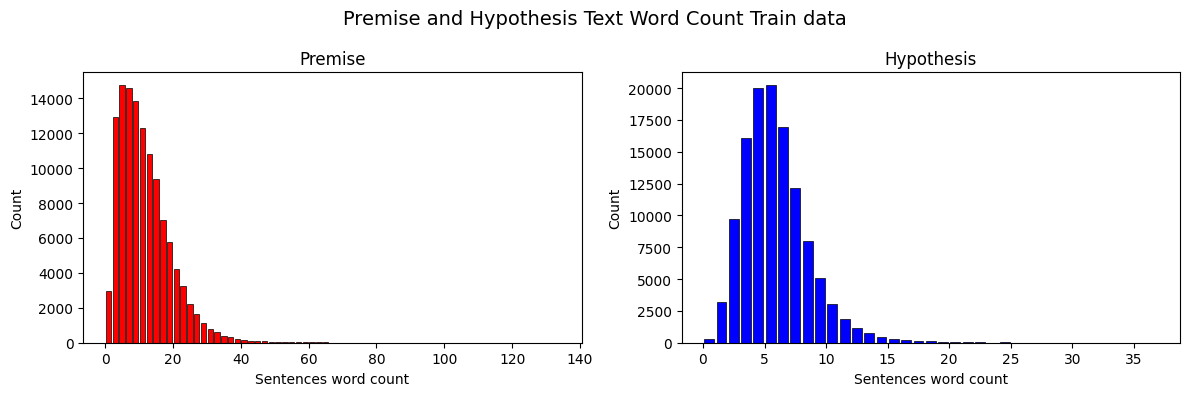

In [83]:
plot_word_count(mnli_data_train, 'Premise and Hypothesis Text Word Count Train data')

Now for matched one

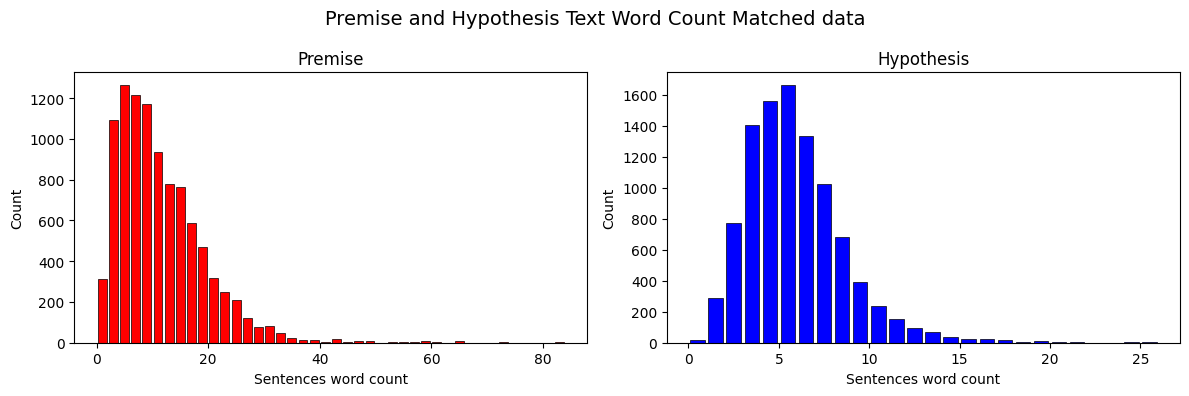

In [84]:
plot_word_count(mnli_data_val_test_m, 'Premise and Hypothesis Text Word Count Matched data')

And mismatched one

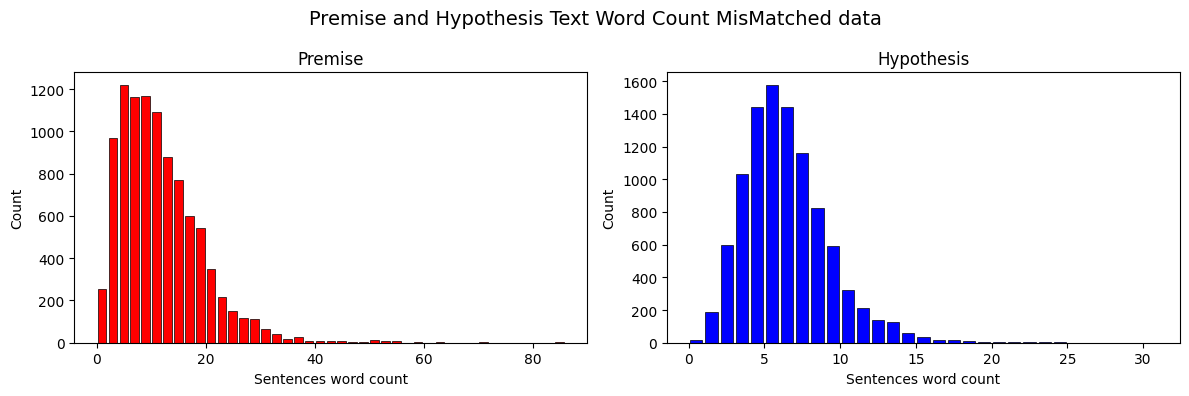

In [85]:
plot_word_count(mnli_data_val_test_mm, 'Premise and Hypothesis Text Word Count MisMatched data')

Okay, now we are interested in statistics. What are the percentiles of word count for both hypothesis and premises for all datasets? In such way we can see how long are usually our normalized sentences

In [86]:
def print_percentile_table(df, name):
  """Takes a Pandas DataFrame column as input and prints a pretty table with
      percentile information on a specific column of the DataFrame
  """
  # Compute the percentiles and max length
  percentiles = df.quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999])
  max_length = df.max()

  # Create a pretty table for the results
  table = PrettyTable()
  table.field_names = ['Percentile', f'{name} Length']
  for p in percentiles.index:
      table.add_row([f'{round(p*100, 3)}%', f'{int(percentiles[p])}'])
  table.add_row(['Max', f'{int(max_length)}'])

  # Print the table
  return(str(table))

Let's see firstly the stats for train dataset

In [87]:
# Create a list of tables to print side by side
tables = [
    print_percentile_table(mnli_data_train['premise_word_count'], 'Train Premise'),
    print_percentile_table(mnli_data_train['hypothesis_word_count'], 'Train Hypothesis')
]

# Print the tables side by side
print(tabulate([tables], headers=['', ''], tablefmt='plain',  numalign='center'))


+------------+----------------------+  +------------+-------------------------+
| Percentile | Train Premise Length |  | Percentile | Train Hypothesis Length |
+------------+----------------------+  +------------+-------------------------+
|   10.0%    |          3           |  |   10.0%    |            2            |
|   25.0%    |          5           |  |   25.0%    |            4            |
|   50.0%    |          10          |  |   50.0%    |            5            |
|   75.0%    |          15          |  |   75.0%    |            7            |
|   90.0%    |          21          |  |   90.0%    |            9            |
|   95.0%    |          25          |  |   95.0%    |            10           |
|   99.0%    |          36          |  |   99.0%    |            14           |
|   99.5%    |          42          |  |   99.5%    |            16           |
|   99.9%    |          63          |  |   99.9%    |            21           |
|    Max     |         134          |  

Okay, we have that 99% of premise sentences are at most 36 words long, while for hypothesis such statistics is 14. Let's look now at matched dataset.

In [88]:
tables = [
    print_percentile_table(mnli_data_val_test_m['premise_word_count'], 'Matched Premise'),
    print_percentile_table(mnli_data_val_test_m['hypothesis_word_count'], 'Matched Hypothesis')
]
print(tabulate([tables], headers=['', ''], tablefmt='plain',  numalign='center'))


+------------+------------------------+  +------------+---------------------------+
| Percentile | Matched Premise Length |  | Percentile | Matched Hypothesis Length |
+------------+------------------------+  +------------+---------------------------+
|   10.0%    |           3            |  |   10.0%    |             2             |
|   25.0%    |           5            |  |   25.0%    |             3             |
|   50.0%    |           9            |  |   50.0%    |             5             |
|   75.0%    |           15           |  |   75.0%    |             7             |
|   90.0%    |           21           |  |   90.0%    |             9             |
|   95.0%    |           25           |  |   95.0%    |             10            |
|   99.0%    |           35           |  |   99.0%    |             14            |
|   99.5%    |           43           |  |   99.5%    |             16            |
|   99.9%    |           64           |  |   99.9%    |             20     

here 99-th percentile for premise sentences is 35, while for hypothesis - 14. The results are almost the same as for train set. Now let's look at mismatched!

In [89]:
tables = [
    print_percentile_table(mnli_data_val_test_mm['premise_word_count'], 'Mismatched Premise'),
    print_percentile_table(mnli_data_val_test_mm['hypothesis_word_count'], 'Mismatched Hypothesis')
]
print(tabulate([tables], headers=['', ''], tablefmt='plain',  numalign='center'))


+------------+---------------------------+  +------------+------------------------------+
| Percentile | Mismatched Premise Length |  | Percentile | Mismatched Hypothesis Length |
+------------+---------------------------+  +------------+------------------------------+
|   10.0%    |             3             |  |   10.0%    |              3               |
|   25.0%    |             6             |  |   25.0%    |              4               |
|   50.0%    |             10            |  |   50.0%    |              6               |
|   75.0%    |             15            |  |   75.0%    |              7               |
|   90.0%    |             20            |  |   90.0%    |              9               |
|   95.0%    |             25            |  |   95.0%    |              11              |
|   99.0%    |             36            |  |   99.0%    |              15              |
|   99.5%    |             44            |  |   99.5%    |              17              |
|   99.9%

Again, very close statistics - 99th percentile for premise = 36 and for hypothesis it is 15. 

As we can see, at most 99.9% of data has 64 word count among all datasets, thus let's trim the sentences to have at most a bit more - 80 words.

In [90]:
def trim_sentence(sentence, max_length):
  """Trim the sentence to have an appropriate number of words (not greater
      than max number)."""
  try:
    sentence = sentence.split()
    sentence = sentence[:max_length]
    return " ".join(sentence)
  except:
    return sentence

Let's apply "trimming" for all 3 datasets now:)

In [91]:
max_length = 80
mnli_data_train['premise'] = mnli_data_train['premise'].apply(lambda x: trim_sentence(x, max_length))
mnli_data_train['hypothesis'] = mnli_data_train['hypothesis'].apply(lambda x: trim_sentence(x, max_length))

In [92]:
mnli_data_val_test_m['premise'] = mnli_data_val_test_m['premise'].apply(lambda x: trim_sentence(x, max_length))
mnli_data_val_test_m['hypothesis'] = mnli_data_val_test_m['hypothesis'].apply(lambda x: trim_sentence(x, max_length))

In [93]:
mnli_data_val_test_mm['premise'] = mnli_data_val_test_mm['premise'].apply(lambda x: trim_sentence(x, max_length))
mnli_data_val_test_mm['hypothesis'] = mnli_data_val_test_mm['hypothesis'].apply(lambda x: trim_sentence(x, max_length))

Now let's see whether it works. We can take a look now at new mnli_data_train dataset and see its word count stats and plot the plots we used before

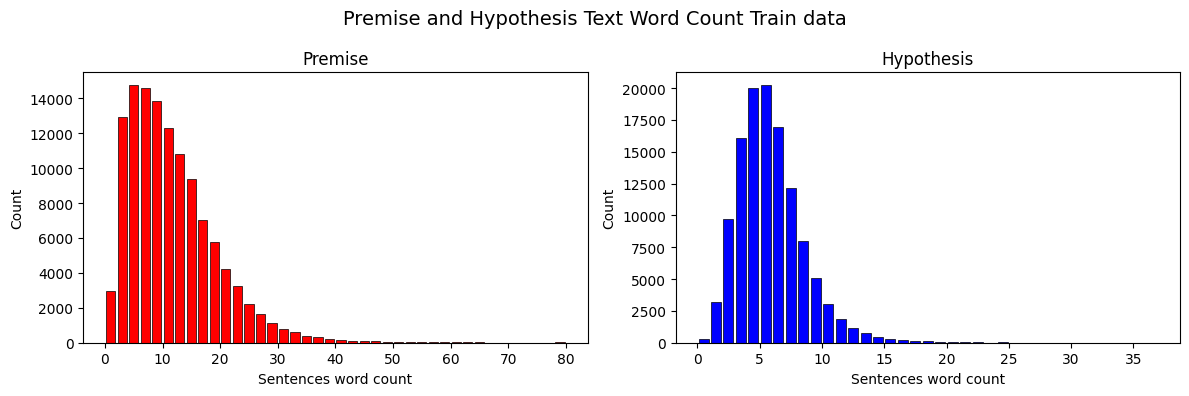

In [94]:
mnli_data_train['premise_word_count'] = mnli_data_train['premise'].apply(lambda x: len(str(x).split()))

mnli_data_train['hypothesis_word_count'] = mnli_data_train['hypothesis'].apply(lambda x: len(str(x).split()))

plot_word_count(mnli_data_train, 'Premise and Hypothesis Text Word Count Train data')

As we can see, now the right tail of premise data is shorter and is at most 80 (max_number). The hypothesis data did not change as it mostly had shorter sentences. Now let's look at precise stats

In [95]:
tables = [
    print_percentile_table(mnli_data_train['premise_word_count'], 'Mismatched Premise'),
    print_percentile_table(mnli_data_train['hypothesis_word_count'], 'Mismatched Hypothesis')
]
print(tabulate([tables], headers=['', ''], tablefmt='plain',  numalign='center'))


+------------+---------------------------+  +------------+------------------------------+
| Percentile | Mismatched Premise Length |  | Percentile | Mismatched Hypothesis Length |
+------------+---------------------------+  +------------+------------------------------+
|   10.0%    |             3             |  |   10.0%    |              2               |
|   25.0%    |             5             |  |   25.0%    |              4               |
|   50.0%    |             10            |  |   50.0%    |              5               |
|   75.0%    |             15            |  |   75.0%    |              7               |
|   90.0%    |             21            |  |   90.0%    |              9               |
|   95.0%    |             25            |  |   95.0%    |              10              |
|   99.0%    |             36            |  |   99.0%    |              14              |
|   99.5%    |             42            |  |   99.5%    |              16              |
|   99.9%

Yes, it definetely worked, as not at max our word count is 80!

Another important thing is now to look at the length of sentences for each label, so that the model does not learns that some label is mostly shorter/longer than others, thus potentially making more mistakes during prediction of values. Let's look at the statistics for each label for our train dataset.

In [96]:
# Define a function to compute word count
def word_count(sentence):
    words = sentence.split()
    return len(words)

def label_stats_table(df, col_name):
    # Compute word count for each sentence
    count_col_name = f'{col_name}_word_count'
    df[count_col_name] = df[col_name].apply(word_count)

    # Compute stats for each label and column
    label_stats = {}
    for label in sorted(df['label'].unique()):
        subset = df[df['label'] == label]
        label_stats[label] = {'min': subset[count_col_name].min(),
                              'max': subset[count_col_name].max(),
                              'mean': subset[count_col_name].mean(),
                              'std': subset[count_col_name].std(),
                              '50th percentile': np.percentile(subset[count_col_name], 50),
                              '90th percentile': np.percentile(subset[count_col_name], 90),
                              '99th percentile': np.percentile(subset[count_col_name], 99),
                              'count': len(subset)}

    # Create a table with the stats for each label and column
    headers = ['Label', f'Min', f'Max', f'Mean', f'Std', f'50th Percentile', f'90th Percentile', f'99th Percentile', 'Count']
    table = []
    for label in label_stats:
        row = [label]
        for stat in label_stats[label]:
            row.append(label_stats[label][stat])
        table.append(row)

    # Print the table with centered alignment
    print(tabulate(table, headers=headers, tablefmt='fancy_grid', colalign=('center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center')))


In [97]:
label_stats_table(mnli_data_train, 'premise')

╒═══════════════╤═══════╤═══════╤═════════╤═════════╤═══════════════════╤═══════════════════╤═══════════════════╤═════════╕
│     Label     │  Min  │  Max  │  Mean   │   Std   │  50th Percentile  │  90th Percentile  │  99th Percentile  │  Count  │
╞═══════════════╪═══════╪═══════╪═════════╪═════════╪═══════════════════╪═══════════════════╪═══════════════════╪═════════╡
│ contradiction │   0   │  80   │ 11.2368 │ 7.84202 │        10         │        21         │        36         │  40000  │
├───────────────┼───────┼───────┼─────────┼─────────┼───────────────────┼───────────────────┼───────────────────┼─────────┤
│  entailment   │   0   │  80   │ 11.1939 │ 7.84231 │        10         │        21         │        36         │  40000  │
├───────────────┼───────┼───────┼─────────┼─────────┼───────────────────┼───────────────────┼───────────────────┼─────────┤
│    neutral    │   0   │  80   │ 11.215  │ 7.90559 │        10         │        21         │        36         │  40000  │
╘═══════

In [98]:
label_stats_table(mnli_data_train, 'hypothesis')

╒═══════════════╤═══════╤═══════╤═════════╤═════════╤═══════════════════╤═══════════════════╤═══════════════════╤═════════╕
│     Label     │  Min  │  Max  │  Mean   │   Std   │  50th Percentile  │  90th Percentile  │  99th Percentile  │  Count  │
╞═══════════════╪═══════╪═══════╪═════════╪═════════╪═══════════════════╪═══════════════════╪═══════════════════╪═════════╡
│ contradiction │   0   │  28   │ 5.00915 │ 2.53583 │         5         │         8         │        13         │  40000  │
├───────────────┼───────┼───────┼─────────┼─────────┼───────────────────┼───────────────────┼───────────────────┼─────────┤
│  entailment   │   0   │  34   │ 5.42625 │ 2.87493 │         5         │         9         │        15         │  40000  │
├───────────────┼───────┼───────┼─────────┼─────────┼───────────────────┼───────────────────┼───────────────────┼─────────┤
│    neutral    │   0   │  37   │ 5.74472 │ 2.62275 │         5         │         9         │        14         │  40000  │
╘═══════

As you can see, for both hypothesis and premise sentences, we have very close statistics for each label, so there is no "longer" or "shorter" label in our dataset :)

Now let's save our preprocessed datasets to separate csv files. But firstly we will drop unnecessary columns premise_word_count and hypothesis_word_count (as we needed them only for statistics and analysis)

In [99]:
mnli_data_train.drop(['premise_word_count', 'hypothesis_word_count'], axis=1, inplace=True)

Check whether it worked

In [100]:
mnli_data_train.head()

,label,genre,premise,hypothesis
0,contradiction,telephone,uh real life,find real
1,entailment,fiction,promise blue grass training suh,promise get blue grass training
2,neutral,government,company plan eventually achieving quantum leap...,many company s plans hindered lack resources
3,entailment,travel,elda noted excellent wine lace making,elda excellent wine
4,contradiction,slate,"one thousand, nine hundred and eighty-six sued...",ian hamilton s biography published without cha...


Do the same for matched and mismatched datasets

In [101]:
mnli_data_val_test_m.drop(['premise_word_count', 'hypothesis_word_count'], axis=1, inplace=True)
mnli_data_val_test_mm.drop(['premise_word_count', 'hypothesis_word_count'], axis=1, inplace=True)

### Save preprocessed data

Save data to Drive folder and we are done

In [102]:
mnli_data_train.to_csv('/content/drive/MyDrive/ml-project-data-try/mnli_data_train.csv', index=False)
mnli_data_val_test_m.to_csv('/content/drive/MyDrive/ml-project-data-try/mnli_data_val_test_matched.csv', index=False)
mnli_data_val_test_mm.to_csv('/content/drive/MyDrive/ml-project-data-try/mnli_data_val_test_mismatched.csv', index=False)